In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b0')

In [ ]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from torch.utils.data import Dataset, DataLoader

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_name(model_name, num_classes=10)


224


In [ ]:
learning_rate=0.001
batch_size  = 128
epoch_num = 100
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = './train/'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
stl10_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize(96),
                                    transforms.RandomCrop(96, padding=4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(15),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, valid_idx = train_test_split(list(range(len(stl10_dataset))), test_size=0.1, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(stl10_dataset, train_idx)
datasets['valid'] = Subset(stl10_dataset, valid_idx)

## data loader
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)


normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
test_transform = transforms.Compose([transforms.Resize(96),
    transforms.ToTensor(),
    normalize
])

# test_dataset = torchvision.datasets.ImageFolder('./test/', transform=test_transform)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

testset=torchvision.datasets.STL10(root='./data', split='test')
            

batch_num['train'], batch_num['valid'] = len(dataloaders['train']), len(dataloaders['valid'])
print('batch_size : %d,  tvt : %d / %d ' % (batch_size, batch_num['train'], batch_num['valid']))



batch_size : 128,  tvt : 36 / 4 


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10.0
    train_loss, train_acc, valid_loss, valid_acc= [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.5f} Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))
           
    


            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                best_idx = epoch
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                model.load_state_dict(best_model_wts)
                torch.save(model.state_dict(), './stl10_model_epoch_%d.pth'%(epoch))
        
        Category = []
        correct=0
        model.eval()
        for input, _ in test_loader:
            input = input.cuda()
            output = model(input)
            output = torch.argmax(output, dim=1)
            answer = output.tolist()
            Category = Category + output.tolist()

        for i in range(8000):
            if Category[i]==testset.__getitem__(i)[1]:
                correct=correct+1
        print("correct : %d / 8000" %(correct))
        print("accuracy : %0.3f\n" %(correct/8000))






    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.5f' %(best_idx, best_loss))

    return model, best_idx, best_loss, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft=optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)


In [ ]:
#training part 

model, best_idx, best_loss, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, num_epochs=epoch_num)


Epoch 0/99
----------
train Loss: 2.04589 Acc: 22.249
valid Loss: 2.31129 Acc: 8.383
correct : 800 / 8000
accuracy : 0.100

Epoch 1/99
----------
train Loss: 1.68474 Acc: 31.588
valid Loss: 2.35614 Acc: 7.585
correct : 800 / 8000
accuracy : 0.100

Epoch 2/99
----------
train Loss: 1.49659 Acc: 39.796
valid Loss: 2.46381 Acc: 7.585
correct : 800 / 8000
accuracy : 0.100

Epoch 3/99
----------
train Loss: 1.33218 Acc: 48.758
valid Loss: 2.62818 Acc: 7.585
correct : 800 / 8000
accuracy : 0.100

Epoch 4/99
----------
train Loss: 1.14959 Acc: 56.788
valid Loss: 2.91827 Acc: 7.585
correct : 800 / 8000
accuracy : 0.100

Epoch 5/99
----------
train Loss: 0.94625 Acc: 64.973
valid Loss: 3.05963 Acc: 7.585
correct : 800 / 8000
accuracy : 0.100

Epoch 6/99
----------
train Loss: 0.78001 Acc: 71.739
valid Loss: 3.28771 Acc: 8.383
correct : 800 / 8000
accuracy : 0.100

Epoch 7/99
----------
train Loss: 0.63137 Acc: 77.507
valid Loss: 3.96746 Acc: 7.585
correct : 800 / 8000
accuracy : 0.100

Epoch 8/

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")

Number of parameters: 4020358


best model : 0 - 8 / 2.3


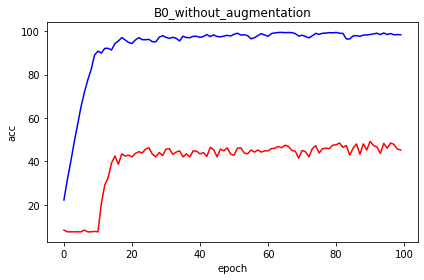

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc[:100], 'b-')
ax1.plot(valid_acc[:100], 'r-')
# plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
plt.title("B0_without_augmentation")
# ax2 = ax1.twinx()
# ax2.plot(train_loss, 'g-')
# ax2.plot(valid_loss, 'k-')
# plt.plot(best_idx, valid_loss[best_idx], 'ro')
# ax2.set_ylabel('loss', color='k')
# ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()